In [1]:
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
from src import geoname_taxonomy_recursive
import os
import matplotlib.pyplot as plt

config = BaseConfig(version=2).get_args(db_name="geonames")

In [2]:
feature_codes_df = DataReader.load_csv(config.feature_codes, sep='\t', 
                                       names=["feature-code", "name", "description"])
feature_codes_df = feature_codes_df.drop(feature_codes_df[feature_codes_df['feature-code'].isnull()].index)
feature_codes_df['level-1'] = feature_codes_df['feature-code'].apply(lambda X: str(X)[0])
feature_codes_df['level-3'] = feature_codes_df['feature-code'].apply(lambda X: str(X)[2:])

level2_mapper = {}
for group, group_df in feature_codes_df.groupby("level-1"):
    group_df_level2_taxonomy = geoname_taxonomy_recursive(group_df['level-3'].tolist(), depth=config.depth)
    print(f"group {group}: number of depth-2 items:‌ {len(group_df_level2_taxonomy)}")
    for depth2_name, depth2_items in group_df_level2_taxonomy.items():
        for depth3_name, depth3_items in depth2_items.items():
                for depth3_item in depth3_items:
                    level2_mapper[depth3_item] = depth3_name

feature_codes_df['level-2'] = feature_codes_df['level-3'].map(level2_mapper)
level3_columns = feature_codes_df.pop("level-3")
feature_codes_df.insert(5, "level-3", level3_columns)
# DataWriter.write_df(feature_codes_df, path=config.processed_feature_codes)

all_countries_df = DataReader.load_csv(config.all_countries, sep='\t', low_memory=False, 
                                       names=["geonameid", "name", "asciiname", "alternatenames","latitude",
                                             "longitude", "feature-class", "feature-code", "country-code", "cc2",
                                             "admin1-code", "admin2-code", "admin3-code", "admin4-code", "population",
                                             "elevation", "dem", "timezone", "modification-date"])[["name", "asciiname", "country-code",
                                                                                                    "feature-class", "feature-code"]]
all_countries_df = all_countries_df.drop(all_countries_df[all_countries_df['feature-class'].isnull()].index)
all_countries_df.rename(columns={"feature-class":"level-1", "feature-code":"level-3"}, inplace=True)
all_countries_df['level-2'] = all_countries_df['level-3'].map(level2_mapper)
level3_columns = all_countries_df.pop("level-3")
all_countries_df.insert(5, "level-3", level3_columns)
# DataWriter.write_df(all_countries_df, path=config.processed_all_countries)

group A: number of depth-2 items:‌ 6
group H: number of depth-2 items:‌ 57
group L: number of depth-2 items:‌ 34
group P: number of depth-2 items:‌ 2
group R: number of depth-2 items:‌ 12
group S: number of depth-2 items:‌ 115
group T: number of depth-2 items:‌ 62
group U: number of depth-2 items:‌ 47
group V: number of depth-2 items:‌ 11


In [3]:
display(all_countries_df.head(5))

display(feature_codes_df.head(5))

print(f"The size of dataset set is:{all_countries_df.shape[0]}")
print(f"The size of feature codes set is:{feature_codes_df.shape[0]}")
print(f"Number of countries are: {len(all_countries_df['country-code'].value_counts())}")
print("-"*50)
print(f"Number of feature codes in Level 1: {len(all_countries_df['level-1'].value_counts())}")
print(f"Number of feature codes in Level 2: {len(all_countries_df['level-2'].value_counts())}")
print(f"Number of feature codes in Level 3: {len(all_countries_df['level-3'].value_counts())}")
print("-"*50)

,name,asciiname,country-code,level-1,level-2,level-3
0,Pic de Font Blanca,Pic de Font Blanca,AD,T,PK,PK
1,Roc Mélé,Roc Mele,AD,T,MT,MT
2,Pic des Langounelles,Pic des Langounelles,AD,T,PK,PK
3,Pic de les Abelletes,Pic de les Abelletes,AD,T,PK,PK
4,Estany de les Abelletes,Estany de les Abelletes,AD,H,LK,LK


,feature-code,name,description,level-1,level-2,level-3
0,A.ADM1,first-order administrative division,a primary administrative division of a country...,A,ADM,ADM1
1,A.ADM1H,historical first-order administrative division,a former first-order administrative division,A,ADM,ADM1H
2,A.ADM2,second-order administrative division,a subdivision of a first-order administrative ...,A,ADM,ADM2
3,A.ADM2H,historical second-order administrative division,a former second-order administrative division,A,ADM,ADM2H
4,A.ADM3,third-order administrative division,a subdivision of a second-order administrative...,A,ADM,ADM3


The size of dataset set is:12350450
The size of feature codes set is:680
Number of countries are: 252
--------------------------------------------------
Number of feature codes in Level 1: 9
Number of feature codes in Level 2: 404
Number of feature codes in Level 3: 675
--------------------------------------------------


Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

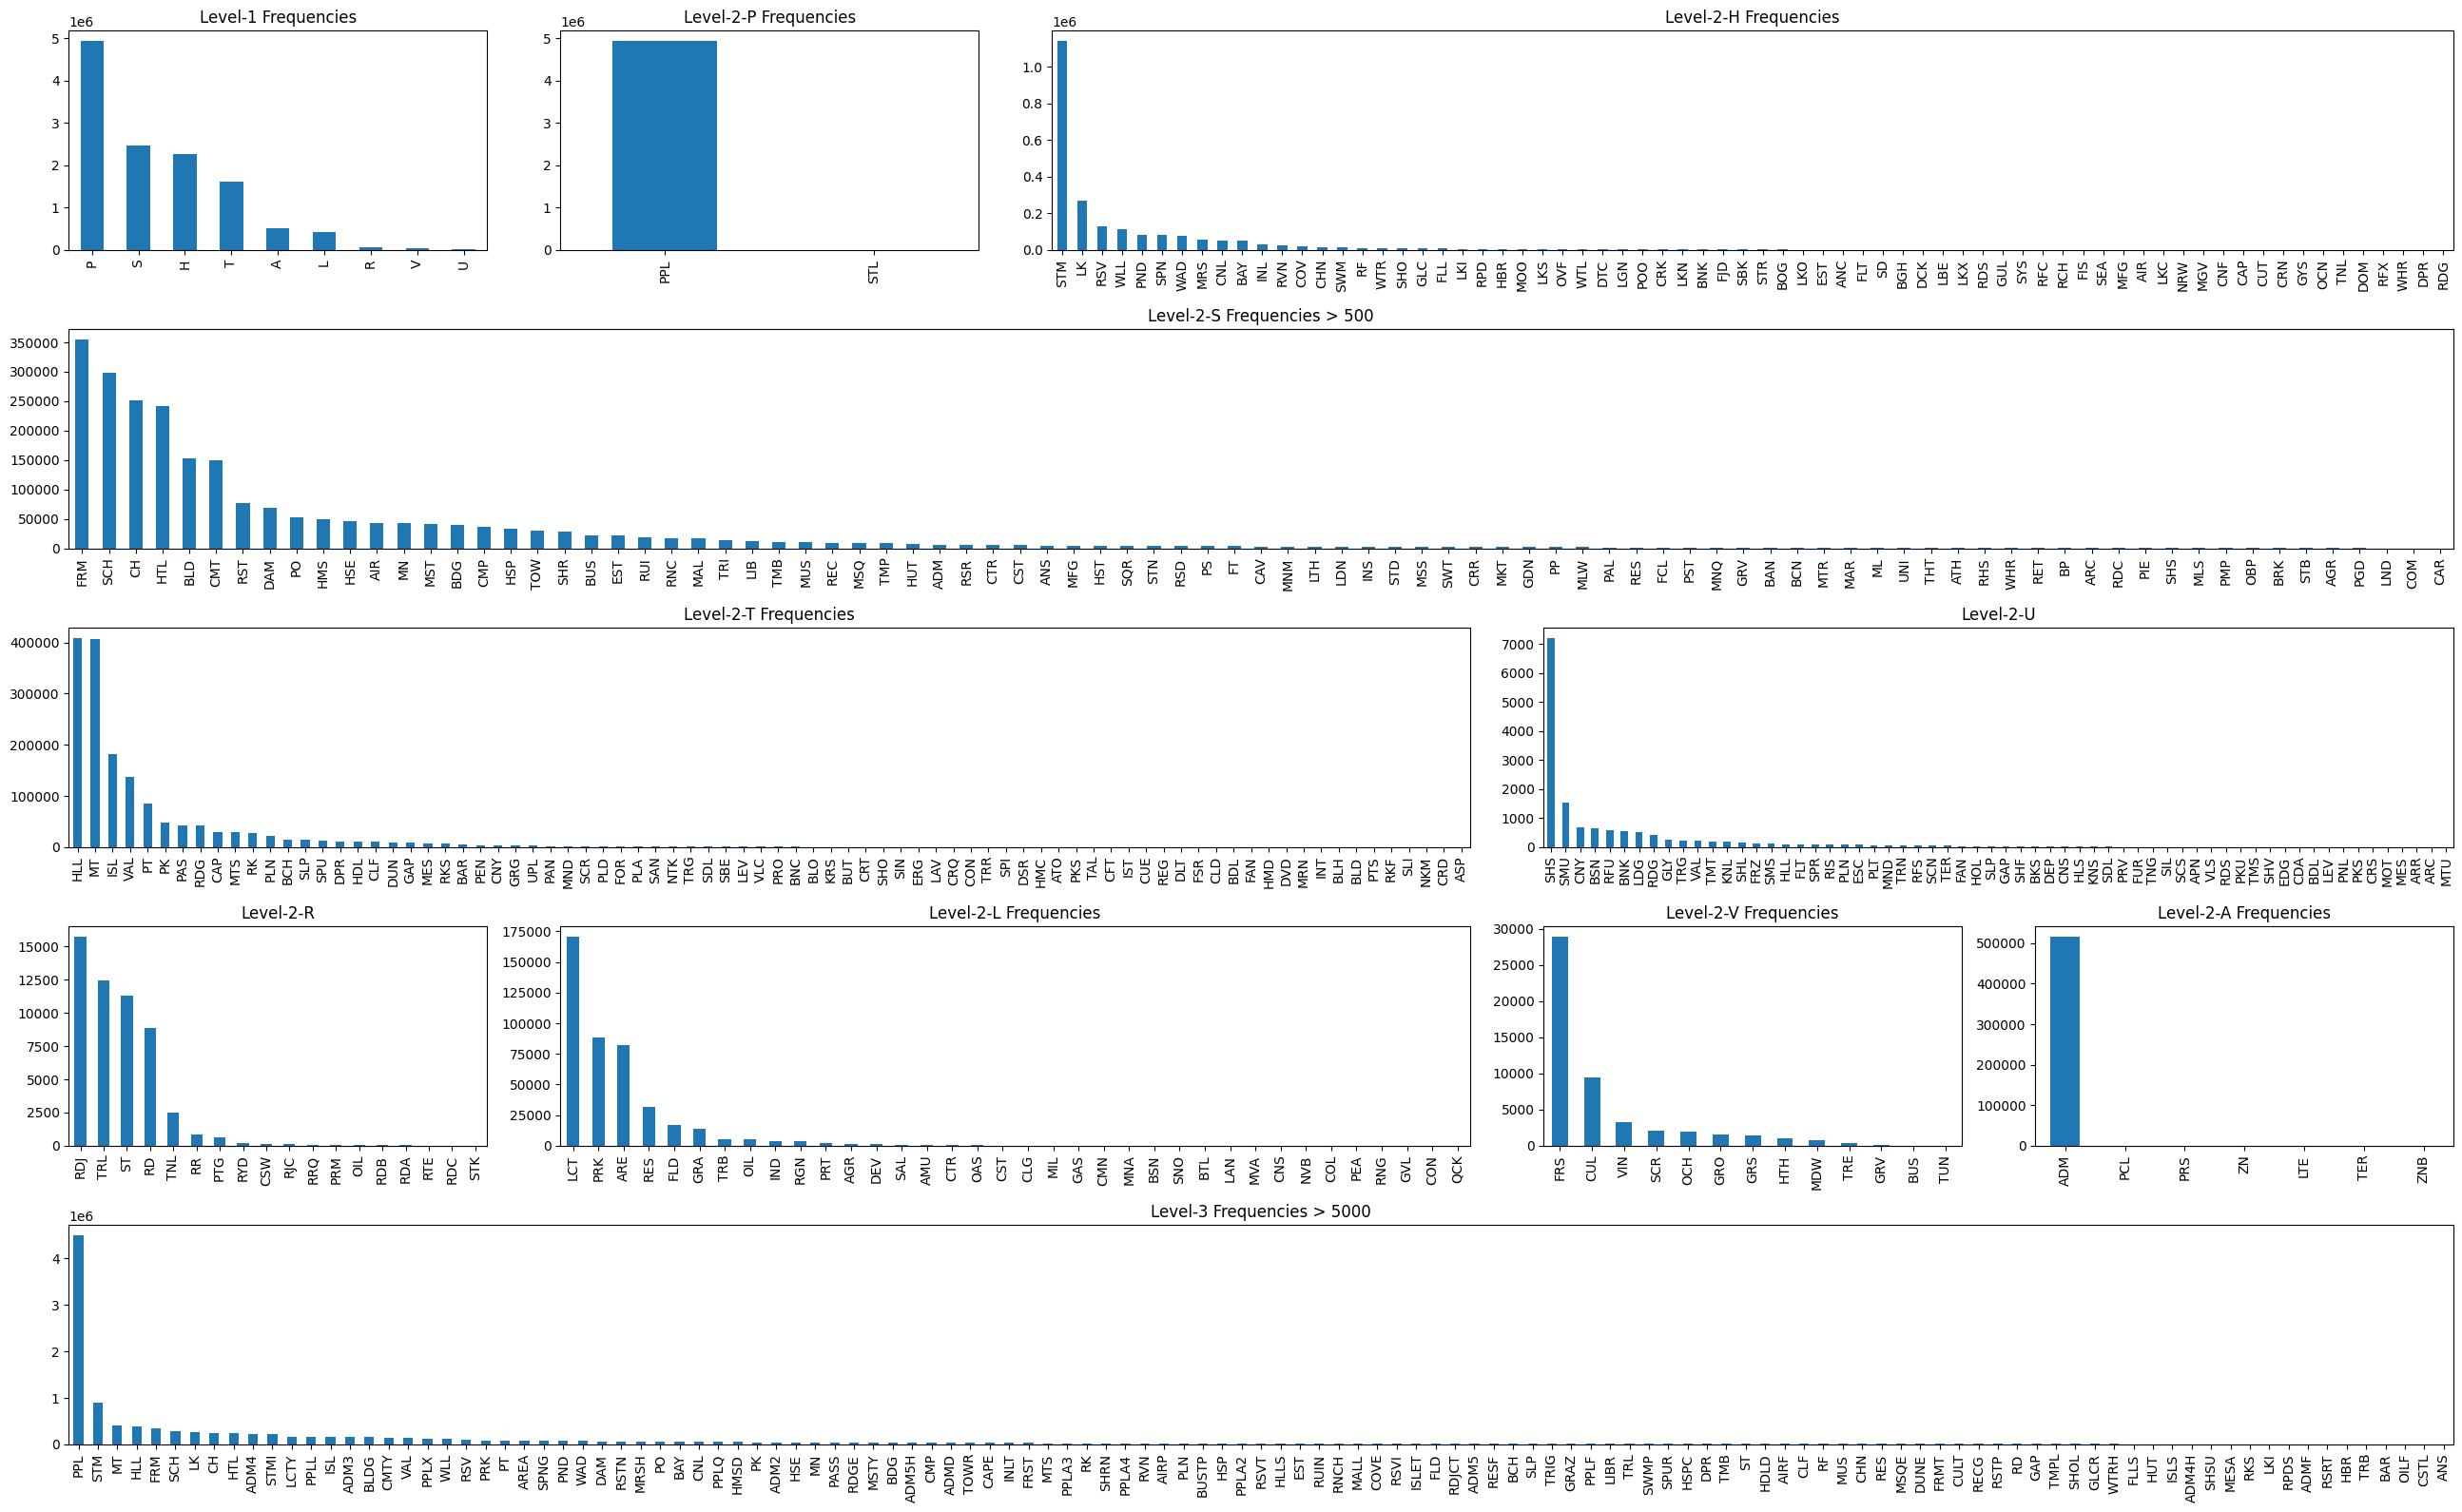

In [7]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().loc[lambda X: X>500].plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

# 2. Make Level 2 reductions

**consider level 2 and set the upper bound for the number of classes, a maximum of 10 top frequent classes were considered in each level.**


In [26]:
def make_level2_reduction(df, max_class_no):
    dfs = []
    for group_name, df in df.groupby("level-1"):
        if len(df['level-2'].unique()) > max_class_no:
            df = df[df['level-2'].isin(list(df['level-2'].value_counts()[:max_class_no].index))]
        dfs.append(df)            
    df = pd.concat(dfs)
    return df

In [27]:
all_countries_df = make_level2_reduction(all_countries_df, max_class_no=10)

Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

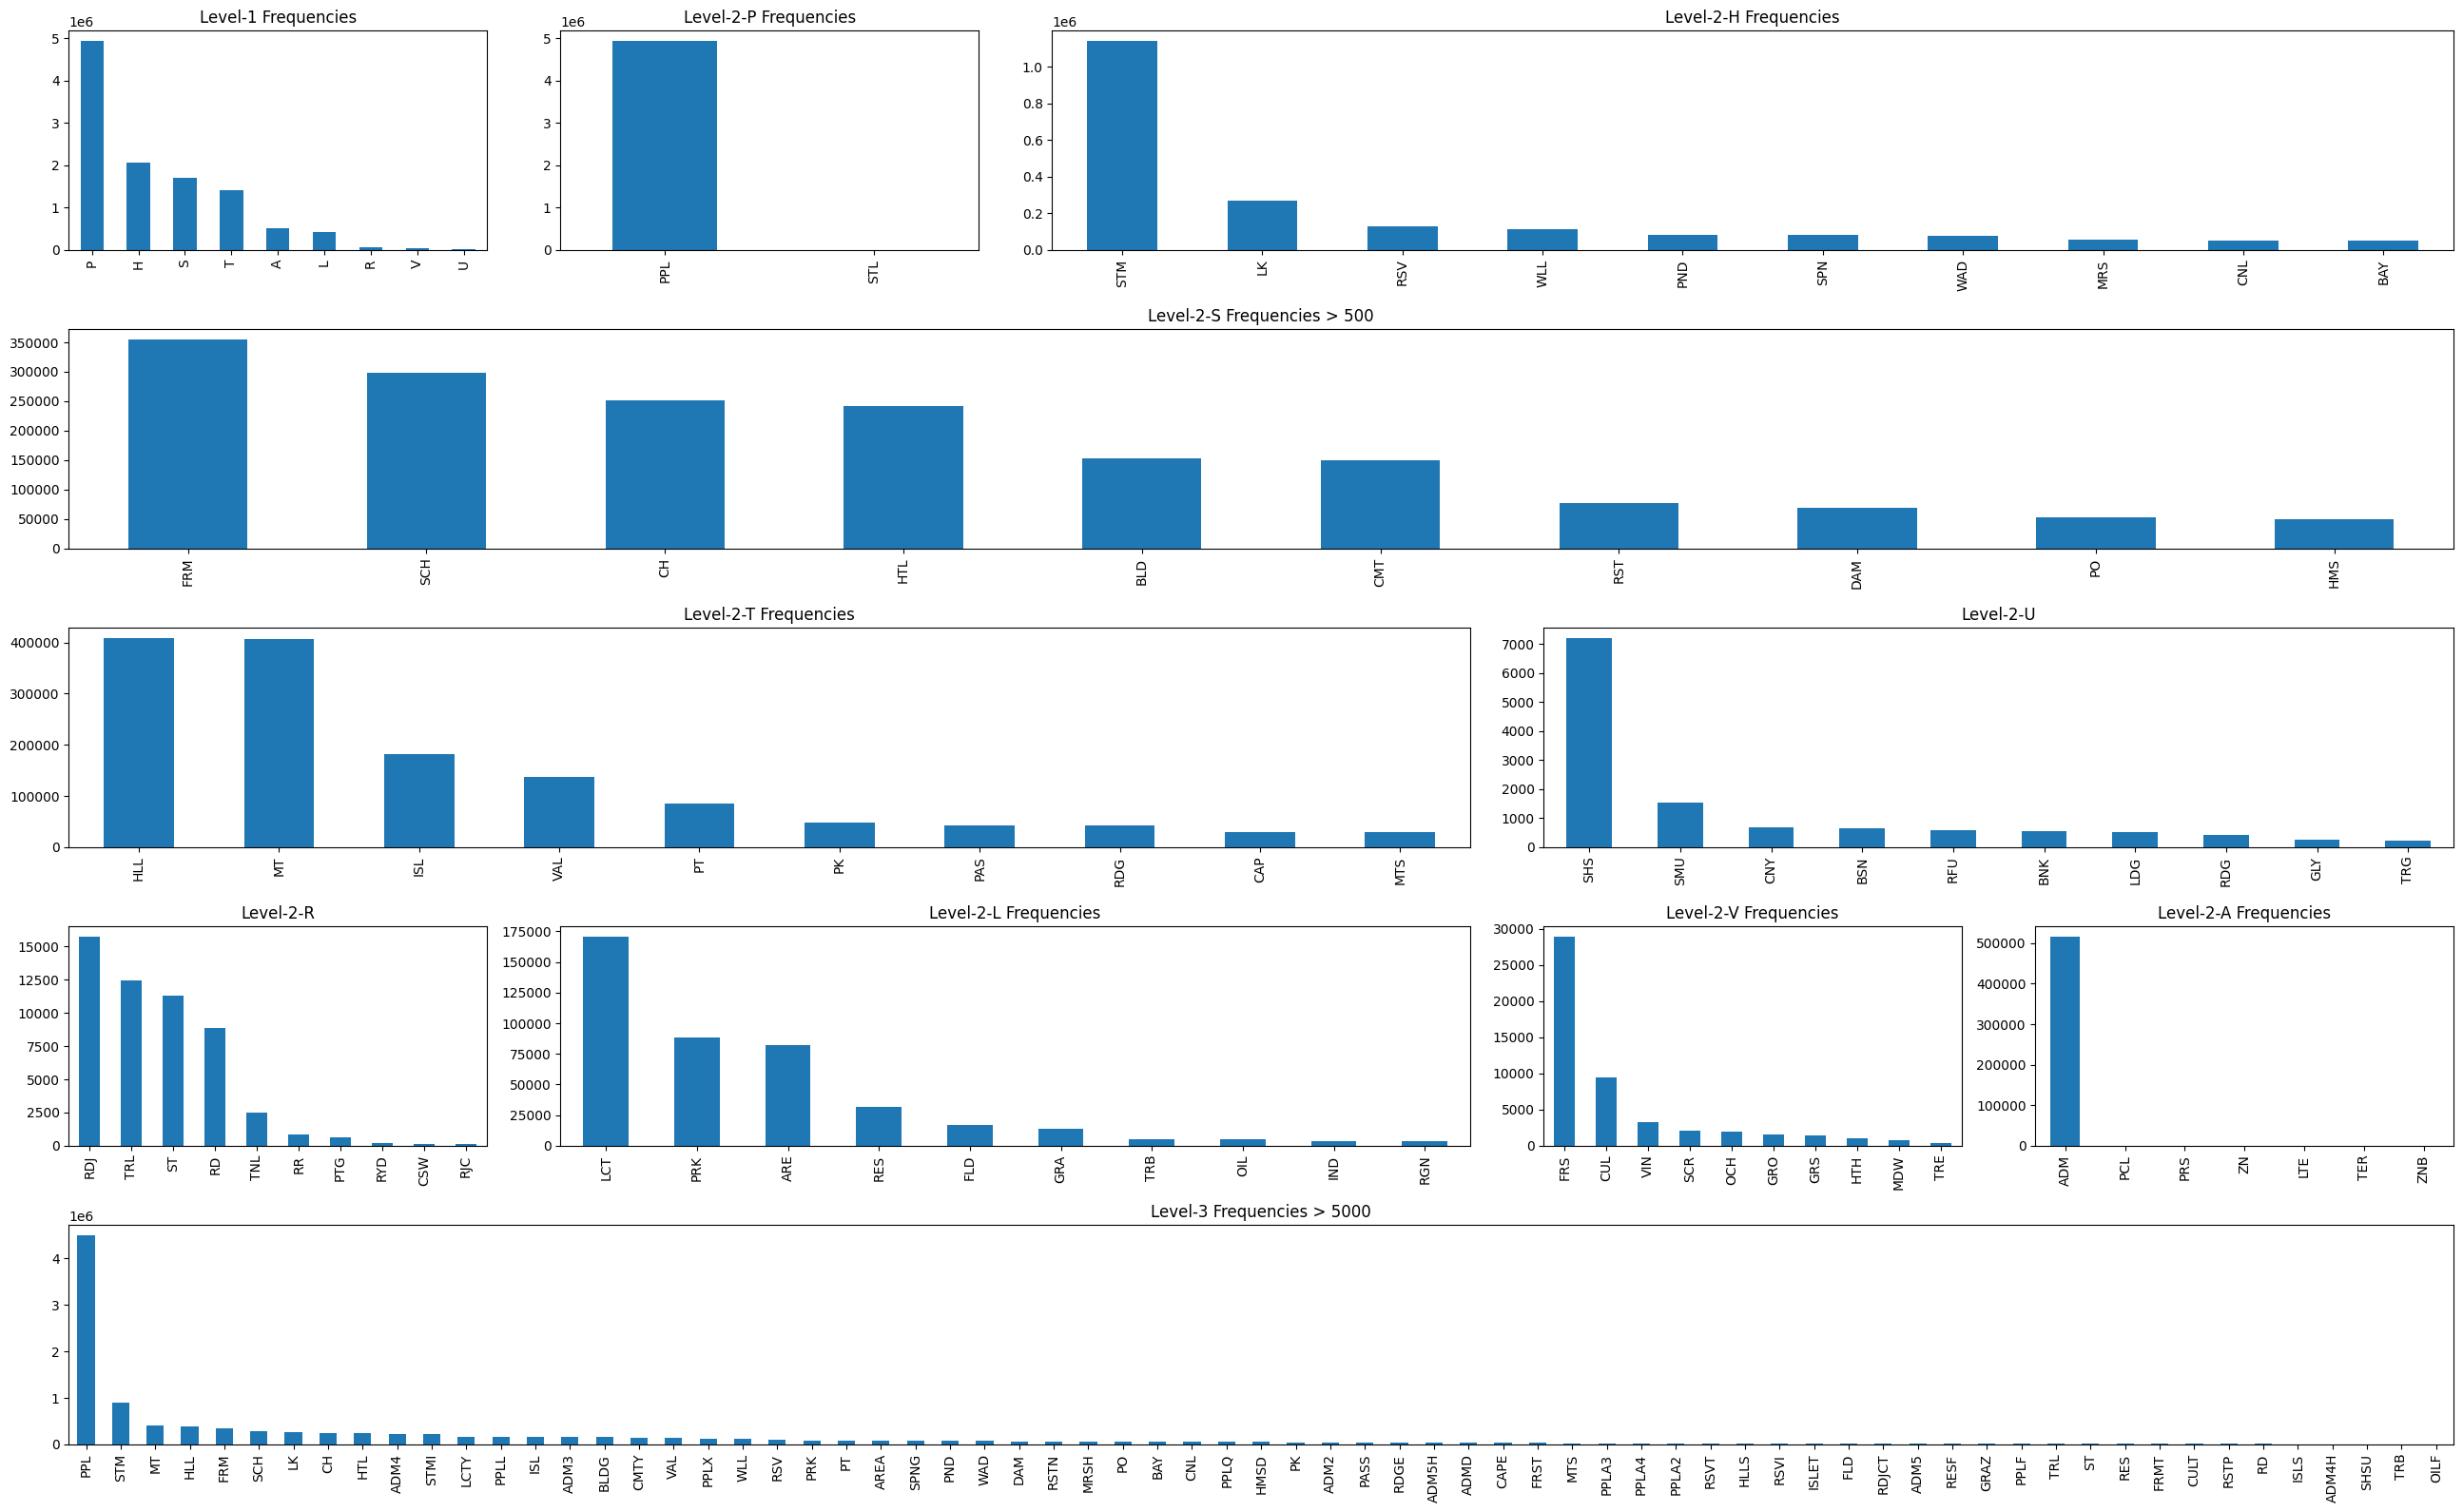

In [28]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().loc[lambda X: X>500].plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

# 3. Make Level 1 based reductions

**Consider level 1 and set the upper bound for the number of samples in each level-1 class based on the frequency of samples in each class frequency less than 1M**


In [30]:
def make_level3_reduction(df, count_no):
    dfs = []
    for group_name, df in df.groupby("level-1"):
        if df.shape[0] > count_no:
            df = df.sample(count_no, random_state=222, replace=False)
        dfs.append(df)            
    df = pd.concat(dfs)
    return df

In [31]:
all_countries_df = make_level3_reduction(all_countries_df, count_no=1_000_000)

Text(0.5, 1.0, 'Level-3 Frequencies > 5000')

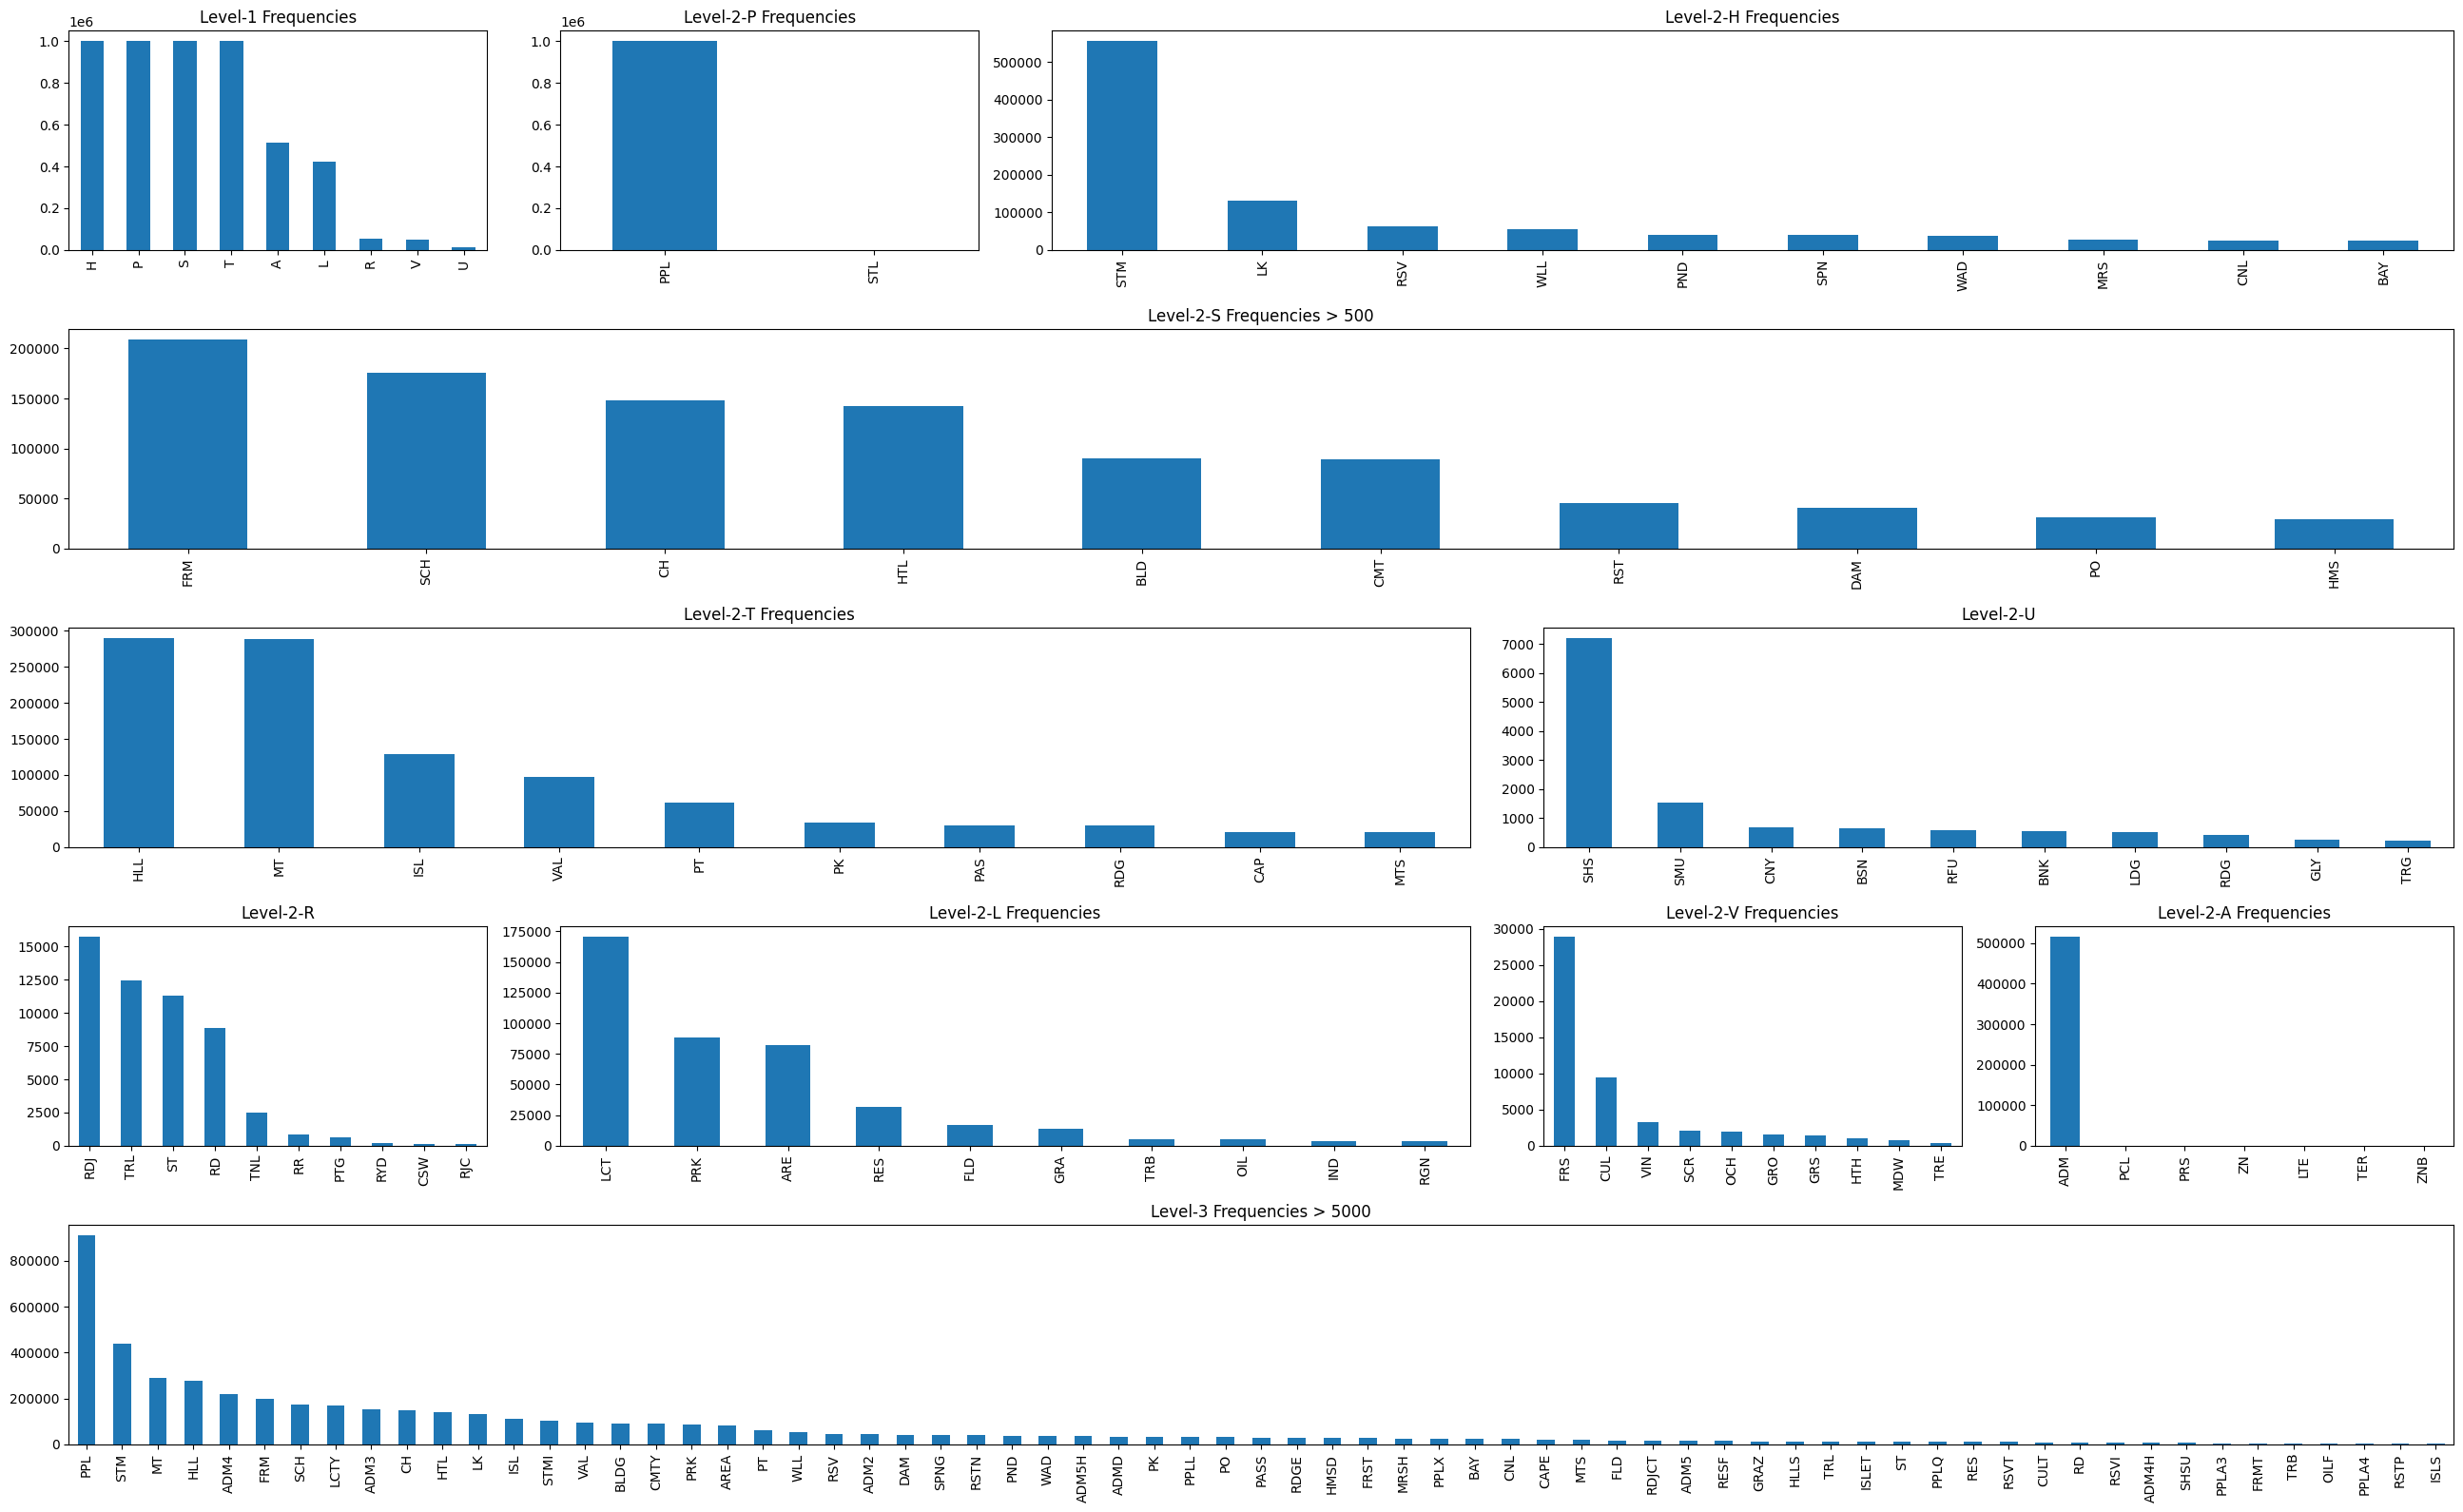

In [32]:
fig = plt.figure(figsize=(26,16))
# plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(5, 5, 1)
all_countries_df['level-1'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('Level-1 Frequencies')

ax2 = fig.add_subplot(5, 5, 2)
all_countries_df.groupby('level-1').get_group("P")['level-2'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('Level-2-P Frequencies')

ax4 = fig.add_subplot(5, 5, (3, 5))
all_countries_df.groupby('level-1').get_group("H")['level-2'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('Level-2-H Frequencies')

ax3 = fig.add_subplot(5, 5, (6, 10))
all_countries_df.groupby('level-1').get_group("S")['level-2'].value_counts().loc[lambda X: X>500].plot(ax=ax3, kind='bar', legend=False)
ax3.set_title('Level-2-S Frequencies > 500')

ax5 = fig.add_subplot(5,5,(11, 13))
all_countries_df.groupby('level-1').get_group("T")['level-2'].value_counts().plot(ax=ax5, kind='bar', legend=False)
ax5.set_title('Level-2-T Frequencies')

ax11 = fig.add_subplot(5, 5, (14, 15))
all_countries_df.groupby('level-1').get_group("U")['level-2'].value_counts().plot(ax=ax11, kind='bar', legend=False)
ax11.set_title('Level-2-U')

ax8 = fig.add_subplot(5, 5, 16)
all_countries_df.groupby('level-1').get_group("R")['level-2'].value_counts().plot(ax=ax8, kind='bar', legend=False)
ax8.set_title('Level-2-R')

ax7 = fig.add_subplot(5, 5, (17, 18))
all_countries_df.groupby('level-1').get_group("L")['level-2'].value_counts().plot(ax=ax7, kind='bar', legend=False)
ax7.set_title('Level-2-L Frequencies')

ax9 = fig.add_subplot(5, 5, 19)
all_countries_df.groupby('level-1').get_group("V")['level-2'].value_counts().plot(ax=ax9, kind='bar', legend=False)
ax9.set_title('Level-2-V Frequencies')

ax6 = fig.add_subplot(5, 5, 20)
all_countries_df.groupby('level-1').get_group("A")['level-2'].value_counts().plot(ax=ax6, kind='bar', legend=False)
ax6.set_title('Level-2-A Frequencies')

ax10 = fig.add_subplot(5, 5, (21, 25))
all_countries_df['level-3'].value_counts().loc[lambda X: X>5000].plot(ax=ax10, kind='bar', legend=False)
ax10.set_title('Level-3 Frequencies > 5000')

In [34]:
print("Current size of dataset is:", all_countries_df.shape[0])

Current size of dataset is: 5053328
